In [23]:
import pandas as pd          # for extracting and manipulating data from dataset
import numpy as np           # for mathematical calculations
import matplotlib.pyplot as plt    # for plotting graphs
from datetime import datetime      # to access datetime
%matplotlib inline                
import warnings                    #  to ignore warnings
warnings.filterwarnings("ignore")

#reading train and test data
train = pd.read_csv ('C:/Users/gaura/Documents/Projects/Python Projects/Time series/Train_SU63ISt.csv')
test = pd.read_csv('C:/Users/gaura/Documents/Projects/Python Projects/Time series/Test_0qrQsBZ.csv')

#We make a copy of the data so that we do not lose the original data even after changes
train_original = train.copy()
test_original = test.copy()


# diving deeper in dataset 
train.columns, test.columns        # features in train and test


(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [24]:
train.shape, test.shape       # dimensions of train and test

((18288, 3), (5112, 2))

In [25]:
# Test data has one less feature which is the target variable count of passengers corresponding to each datetime

train.dtypes, test.dtypes      # data tyoes of each feature

train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


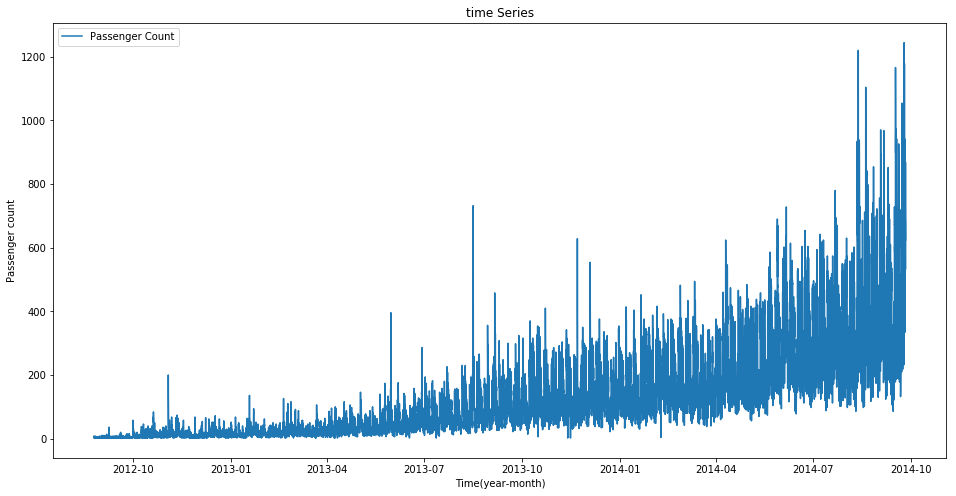

In [36]:
# Changing the object of Datetime in train and test data to 'datetime' to extract features from it
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(test_original.Datetime, format= '%d-%m-%Y %H:%M')
test_original ['Datetime'] = pd.to_datetime(test_original.Datetime, format= '%d-%m-%Y %H:%M')

# To extract the year, month, day and hour to make further analysis
for i in (train, test, test_original, train_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['Hour'] = i.Datetime.dt.hour
    
#To generate weekend and weekday variables
train['day of week '] = train['Datetime'].dt.dayofweek
temp = train ['Datetime']

#We assign 1 if the day of week is weekend and 0 if the day of week is weekday
def applyer(row):
    if row.dayofweek==5 or row.dayofweek == 6:
        return 1
    else:
        return 0
    
train['weekend'] = train ['Datetime'].apply(applyer)

#assigning index as Datetime to get the time period on x-axis.
train.index = train['Datetime']
df = train.drop('ID',1)
ts= train.Count
plt.figure(figsize=(16,8))
plt.plot(ts, label = 'Passenger Count')
plt.title ('time Series')
plt.xlabel('Time(year-month)')
plt.ylabel ('Passenger count')
plt.legend(loc = 'best')

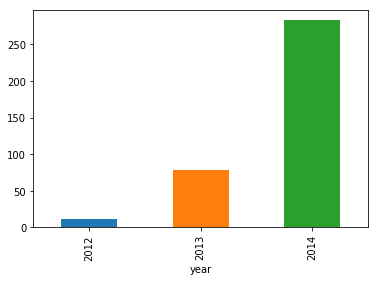

In [51]:
#General trend is increase in passenger count with increase in time. Next we do EXPLORATORY ANALYSIS

#To check yearly passenger count
train.groupby('year')['Count'].mean().plot.bar()

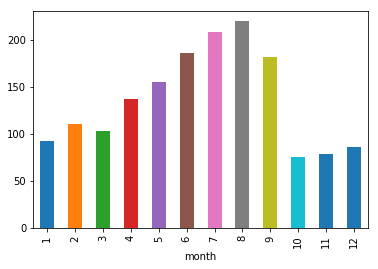

In [46]:
# Passenger count increase exponentially with increase in years. Let's check for months.

train.groupby('month')['Count'].mean().plot.bar()

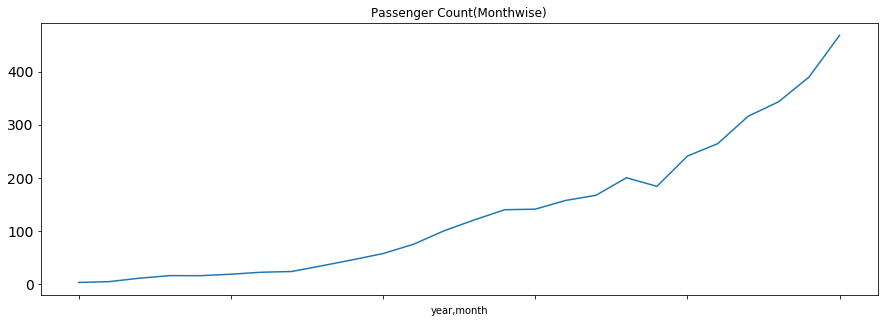

In [56]:
# we see a monthly decrease in the mean of passenger count in last three months
temp  = train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize = (15,5), title = 'Passenger Count(Monthwise)', fontsize = 14)

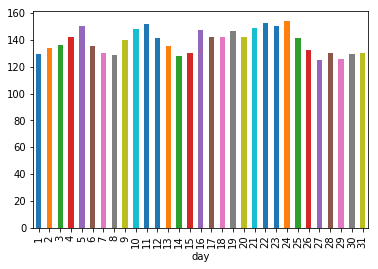

In [59]:
#Year 2014 does not has last three months that is the reason we are getting less counts for these months
train.groupby('day')['Count'].mean().plot.bar()

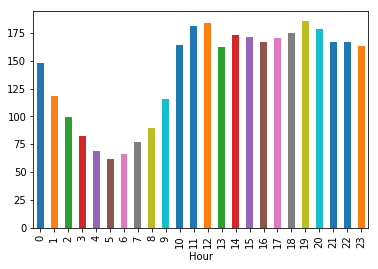

In [61]:
#not much insights available from day wise counts. Let's check the mean of hourly passenger count
train.groupby('Hour')['Count'].mean().plot.bar()

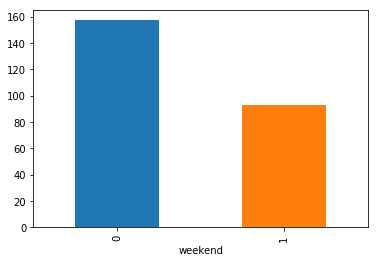

In [63]:
#Peak traffic os at 7 pm and then it decreases till 5 am. Let's check the traffic trend for weekends.
train.groupby('weekend')['Count'].mean().plot.bar()

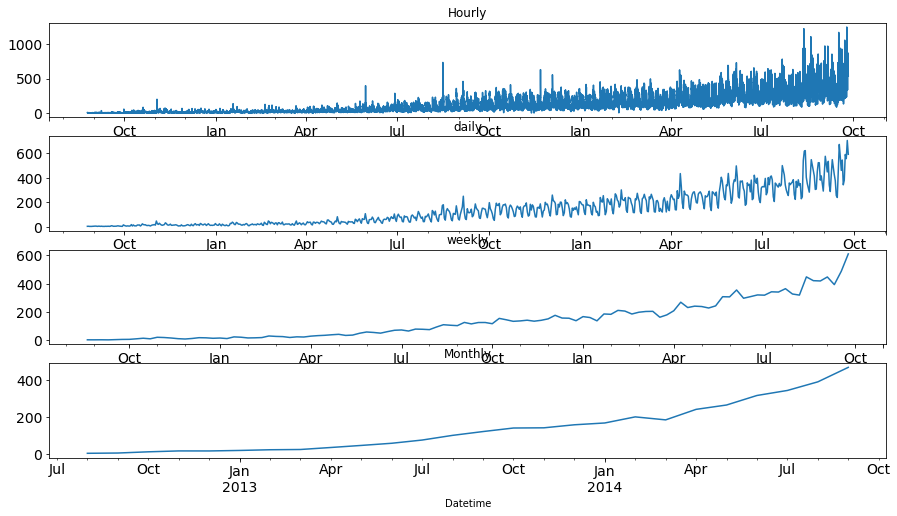

In [68]:
#Clearly traffic is more on weekdays than weekends.
# Before oving forward to modelling we have to drop the ID variable as it has got nothing to do with passenger count


# We aggregate hourly time series to daily, weekly and monthly to reduce the noise and make it more stable for model to learn
hourly = train.resample('H').mean()
daily = train.resample('D').mean()
weekly = train.resample('W').mean()
monthly = train.resample('M').mean()

fig,ax = plt.subplots(4,1)
hourly.Count.plot(figsize= (15,8), title = 'Hourly', fontsize= 14, ax = ax[0])
daily.Count.plot(figsize=(15,8), title = 'daily', fontsize= 14, ax=ax [1])
weekly.Count.plot(figsize=(15,8), title = 'weekly', fontsize = 14, ax = ax [2])
monthly.Count.plot(figsize=(15,8), title = 'Monthly', fontsize= 14, ax = ax [3])

plt.show()


In [70]:
# We can see that the time series is becoming more and more stable. So we will work with the daily time series

test.Timestamp = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')
test.index = test.Timestamp
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index = train.Timestamp
train = train.resample('D').mean()


In [ ]:
# Splitting the data into training and Validation